## STN(Spatial Transformer Network)
  - allow a neural network to learn how to perform spatial transformations on the input image
  - enhance the geometric invariance of the model
  - useful for CNNs because they are not invariant to rotation and scale and more general affine transformations

### Import required librarys

In [1]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

### Loading the Data
experiment with the classic MNIST dataset

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# train accerlerator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## Depicting spatial transformer networks
1. **localization network**: regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
2. **grid generator**: generates a grid of coordinates in the input image corresponding to each pixel from the output image.
3. **sampler**: uses the parameters of the transformation and applies it to the input image.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(  # input: (n, 1, 28, 28)
            nn.Conv2d(1, 8, kernel_size=7),  # (n, 8, 22, 22)
            nn.MaxPool2d(2, stride=2),  # (n, 8, 11, 11)
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 10, kernel_size=5),  # (n, 10, 7, 7)
            nn.MaxPool2d(2, stride=2),  # (n, 10, 3, 3)
            nn.ReLU(inplace=True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):  # input x : (n, 1, 28, 28)
        xs = self.localization(x)  # (n, 10, 3, 3)
        xs = xs.view(-1, 10 * 3 * 3) 
        theta = self.fc_loc(xs)  # (n, 6)
        theta = theta.view(-1, 2, 3)  # (n, 2, 3)

        grid = F.affine_grid(theta, x.size())  # grid generator -> Generates a 2D or 3D flow field (sampling grid), given a batch of affine matrices theta.
        x = F.grid_sample(x, grid)  # sampler -> Given an input and a flow-field grid, computes the output using input values and pixel locations from grid.
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x) # (n, 1, 28, 28)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # (n, 10, 12, 12)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  # (n, 20, 4, 4)
        x = x.view(-1, 320)  # (n, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)  #(n, 10)

        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Training the model
- use the SGD algorithm to train the model.
- The network is learning the classification task in a supervised way.
- In the same time the model is learning STN automatically in an end-to-end fashion.

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for step, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = F.nll_loss(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    step * len(data),
                    len(train_loader.dataset),
                    100. * step / len(train_loader),
                    loss.item()
                )
            )

In [5]:
def test():
    with torch.no_grad():
        model.eval()

        test_loss = 0
        correct = 0

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, size_average=False).item()
            correct += torch.sum(torch.argmax(output, dim=1) == target).item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss,
                correct,
                len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)
            )
        )

## Visualizing the STN results
- inspect the results of our learned visual attention mechanism.
- helper function in order to visualize the transformations while training.

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

/home/minyong-voyagerx/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/minyong-voyagerx/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343216
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.806428


/home/minyong-voyagerx/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2100, Accuracy: 9405/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.589922
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.453328

Test set: Average loss: 0.1277, Accuracy: 9627/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.219264
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.201476

Test set: Average loss: 0.1284, Accuracy: 9593/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.246371
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.399630

Test set: Average loss: 0.1084, Accuracy: 9667/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.245462
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.151106

Test set: Average loss: 0.0787, Accuracy: 9759/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.117256
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.150707

Test set: Average loss: 0.0653, Accuracy: 9800/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.122659
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.317745

Test set: Average loss: 0.0645, Accuracy: 9821/10000 (98%)

Tra

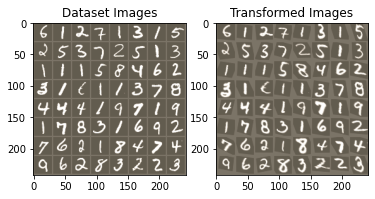

In [7]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

In [8]:
plt.ioff()
plt.show()